In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import itertools
import copy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# State Space

For the state space, we looked at buildings that were affected by the 7.8 magnitude Gorkha earthquake occured near the Gorkha district of Gandaki Pradesh, Nepal. Buildings got different preparedness scores based on how they were impacted by the earthquake:


*   No repair: 0.8 score
*   Minor repair: 0.6

*   Major repair: 0.4
*   Reconstruction: 0.2

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CS238 Final Project /csv_building_structure modified.csv')
NUM_BUILD = 3
# Select ten buildings

# State Space: Preparedness of each building
def generate_state():
  buildings = data.sample(NUM_BUILD)
  state_space = buildings['preparedness'].to_list()
  state_space = np.array(state_space)
  return state_space

state_space = generate_state()
print(state_space)


[0.8 0.2 0.6]


# Actions

For n buildings, There are n + 1 possible actions. For every building $b_i$, we can choose to renovate (action $a_i$), and action $a_0$ stands for not renovating anything. We can renovate at most one building at each time step.

In [ ]:
# Action Space: Renovate Building 1, 2, 3, or No Action (0, 1, 2, 3)
action_space = np.arange(0, NUM_BUILD + 1)
action_space

array([0, 1, 2, 3])

# Transitions

We set the probability of an earthquake to be:
$$p_e = 0.05$$

For every building i, the probability of the preparedness $s_i$ of the building improving after we choose to renovate it would be:

$$T(s_i + 0.2 | s_i, a_i = 1) = 0.9$$
$$T(s_i - 0.6  | s_i, a_i = 1) = p_e = 0.1$$

if we don't renovate the building
$$T(s_i | s_i, a_i = 0) = 0.7$$
$$T(s_i - 0.2 | s_i, a_i = 0) = 0.2$$
$$T(s_i - 0.6  | s_i, a_i = 0) = p_e = 0.1$$



In [ ]:
def transition(state, action):
    # Simulate earthquake
    earthquake = random.random() < 0.1
    #If there is an earthquake:
    if earthquake:
      # print("EARTHQUAKE HAPPENING")
      state = np.maximum(state - 0.6, 0)
    else:
    #If there is no earthquake, we renovate one building, and the preparedness of all other buildings reduces
      decay = random.random() < 0.2
      # decay_mask = np.random.rand(*state.shape) < 0.2
      # state = np.maximum(state - decay_mask * 0.2, 0)
      if decay:
        state = np.maximum(state - 0.2, 0)
      if action != 0:
        if decay:
          state[action - 1] = np.minimum(state[action - 1] + 0.4, 1)
        else:
          state[action - 1] = np.minimum(state[action - 1] + 0.2, 1)
    return state

# Rewards

We want the reward to be the sum of buildings that have a preparedness $s_i$ greater than 0.2, minus the cost of renovations:

$$R = Σ|s_i > 0.2| - \text{# of repairs} - 50 * Σ|s_i < 0.2|$$



In [ ]:
def reward(state, action):
    #We find the number of buildings with preparedness s_i > 0.2
    solid = np.sum(state > 0.2)
    non_solid = np.sum(state <= 0.2)
    if action == 0:
      return solid - 50 * non_solid
    else:
      return solid - 50 * non_solid - 20


#We start with a 1, decays to 0 over 50 years, decays by 0.02


# Random Policy

We're first going to try a random policy:




In [ ]:
def random_policy():
    return random.choice(action_space)

# Q-Learning

**Should we add an exploration policy?**

We estimate the action-value function using the following incremental update rule:


$$Q(s,a) ← Q(s,a)+α(r+γ\max_{a'}Q(s′,a′)−Q(s,a))$$

In [ ]:
from re import I


def create_Q_table(NUM_BUILD):
    q_per_action = np.zeros(NUM_BUILD + 1)
    state_values = np.around(np.arange(0, 1.1, 0.2), decimals=1)
    # # Generate all unique states:
    all_possible_states = list(itertools.product(state_values, repeat=NUM_BUILD))
    rows = []
    dictionary = {}
    for i in range(len(all_possible_states)):
      dictionary[tuple(all_possible_states[i])] = i
      row = np.hstack((all_possible_states[i], q_per_action))
      rows.append(row)
    matrix = np.vstack(rows)
    return matrix, dictionary
    # Generate all unique states:

q_values, state_indexes = create_Q_table(NUM_BUILD)
print(q_values)
print(state_indexes)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.2 ... 0.  0.  0. ]
 [0.  0.  0.4 ... 0.  0.  0. ]
 ...
 [1.  1.  0.6 ... 0.  0.  0. ]
 [1.  1.  0.8 ... 0.  0.  0. ]
 [1.  1.  1.  ... 0.  0.  0. ]]
{(0.0, 0.0, 0.0): 0, (0.0, 0.0, 0.2): 1, (0.0, 0.0, 0.4): 2, (0.0, 0.0, 0.6): 3, (0.0, 0.0, 0.8): 4, (0.0, 0.0, 1.0): 5, (0.0, 0.2, 0.0): 6, (0.0, 0.2, 0.2): 7, (0.0, 0.2, 0.4): 8, (0.0, 0.2, 0.6): 9, (0.0, 0.2, 0.8): 10, (0.0, 0.2, 1.0): 11, (0.0, 0.4, 0.0): 12, (0.0, 0.4, 0.2): 13, (0.0, 0.4, 0.4): 14, (0.0, 0.4, 0.6): 15, (0.0, 0.4, 0.8): 16, (0.0, 0.4, 1.0): 17, (0.0, 0.6, 0.0): 18, (0.0, 0.6, 0.2): 19, (0.0, 0.6, 0.4): 20, (0.0, 0.6, 0.6): 21, (0.0, 0.6, 0.8): 22, (0.0, 0.6, 1.0): 23, (0.0, 0.8, 0.0): 24, (0.0, 0.8, 0.2): 25, (0.0, 0.8, 0.4): 26, (0.0, 0.8, 0.6): 27, (0.0, 0.8, 0.8): 28, (0.0, 0.8, 1.0): 29, (0.0, 1.0, 0.0): 30, (0.0, 1.0, 0.2): 31, (0.0, 1.0, 0.4): 32, (0.0, 1.0, 0.6): 33, (0.0, 1.0, 0.8): 34, (0.0, 1.0, 1.0): 35, (0.2, 0.0, 0.0): 36, (0.2, 0.0, 0.2): 37, (0.2, 0.0, 0.4): 38

In [ ]:
#Old version, will discard
discount_factor = 0.9
learning_rate =  0.01

def QLearning(q_values, indexes, action_space):
    # q_values, indexes = create_Q_table(NUM_BUILD)
    epsilon = 0.95
    epsilon_update = 1
    for i in range(100000):
      state = generate_state()
      row = indexes[tuple(state)]
      # print("state:", state)
      for j in range(50):
        if random.uniform(0, 1) < epsilon:
          action = random.choice(action_space)  #Explore
        else:
          action = np.argmax(q_values[row][NUM_BUILD:])
        next_state = transition(state, action)
        next_state = np.around(next_state, decimals=3)
        next_row = indexes[tuple(next_state)]
        #Get the reward:
        r = reward(next_state, action)
        max_q_value = np.argmax(q_values[next_row][NUM_BUILD:])
        #Update Q(s,a)
        update = discount_factor * (r + learning_rate * max_q_value - q_values[row][NUM_BUILD + action])
        q_values[row][NUM_BUILD + action] += update
        state = next_state
        row = next_row
      if i == epsilon_update * 1000:
        epsilon_update += 1
        epsilon = epsilon - 0.1

    return q_values

  #[0 0 0 1 2]


In [ ]:
q_values = QLearning(q_values, state_indexes, action_space)

# SARSA

### What about SARSA?

In [ ]:
  # Number of buildings
NUM_ACTIONS = NUM_BUILD + 1  # Number of actions including 'no action'
ALPHA = learning_rate  # Learning rate
GAMMA = discount_factor  # Discount factor
EPSILON = 0.1  # Exploration rate
NUM_EPISODES = 100000  # Number of episodes for training
MAX_RENOVATIONS = 50

In [ ]:
state_values = np.around(np.arange(0, 1.1, 0.1), decimals=1)
all_possible_states = list(itertools.product(state_values, repeat=NUM_BUILD))
q_table = np.zeros((len(all_possible_states), NUM_ACTIONS))

In [ ]:
def get_state_index(state):
    return all_possible_states.index(tuple(np.around(state, decimals=1)))

def epsilon_greedy_policy(state):
    if random.random() < EPSILON:
        return random.randint(0, NUM_ACTIONS - 1)
    else:
        state_index = get_state_index(state)
        return np.argmax(q_table[state_index, :])

def update_q_table_sarsa(state, action, reward, next_state, next_action):
    state_index = get_state_index(state)
    next_state_index = get_state_index(next_state)
    q_table[state_index, action] += ALPHA * (reward + GAMMA * q_table[next_state_index, next_action] - q_table[state_index, action])


In [ ]:
# SARSA Learning
for episode in range(NUM_EPISODES):
    state = state_space
    action = epsilon_greedy_policy(state)
    num_renovations = 0

    while True:
        next_state = transition(state, action)
        r = reward(state, action)
        next_action = epsilon_greedy_policy(next_state)

        update_q_table_sarsa(state, action, r, next_state, next_action)

        state = next_state
        action = next_action
        num_renovations += 1 if action != 0 else 0

        if num_renovations >= MAX_RENOVATIONS:
            break
        print(f"Action: {action}, State: {state}, Reward: {r}")

# Evaluation

In [ ]:
def evaluate_random_policy(state, horizon):
  total_reward = 0
  states = [state]
  for i in range(horizon):
    action = random_policy()
    next_state = transition(state, action)
    total_reward += reward(next_state, action)
    state = next_state
    states.append(state)
  return total_reward, states

In [ ]:
def evaluate_q_learning(state, state_indexes, q_values, horizon):
  total_reward = 0
  states = []
  for i in range(horizon):
    state_ind = state_indexes[tuple(state)]
    greedy_action = np.argmax(q_values[state_ind][NUM_BUILD:])
    next_state = transition(state, greedy_action)
    next_state = np.around(next_state, decimals=3)
    total_reward += reward(next_state, greedy_action)
    state = next_state
    states.append(state)
  return total_reward, states

In [ ]:
def evaluate_sarsa(state, q_values, horizon):
  total_reward = 0
  states = []
  for i in range(horizon):
    # state_ind = state_indexes[tuple(state)]
    state_ind = get_state_index(state)
    greedy_action = np.argmax(q_values[state_ind][NUM_BUILD:])
    next_state = transition(state, greedy_action)
    next_state = np.around(next_state, decimals=3)
    total_reward += reward(next_state, greedy_action)
    state = next_state
    states.append(state)
  return total_reward, states

In [ ]:
#Evaluating Q_learning and the random policy
def evaluation(q_values, horizon):
  state = generate_state()
  q_learning_reward = 0
  random_policy_reward = 0
  print("initial state:", state)
  q_learning_reward, q_states = evaluate_q_learning(state, state_indexes, q_values, horizon)
  random_policy_reward, r_states = evaluate_random_policy(state, horizon)
  sarsa_reward, s_states = evaluate_sarsa(state, q_table, horizon)
  return q_learning_reward, random_policy_reward, sarsa_reward, [q_states, r_states, s_states]
  # print("qlearning:", q_learning_reward)
  # print("random policy:", random_policy_reward)
# evaluation(q_values, 300)

initial state: [0.4 0.6 0.4]
initial state: [0.2 0.4 0.2]
initial state: [0.6 0.2 0.4]
initial state: [0.4 0.4 0.2]


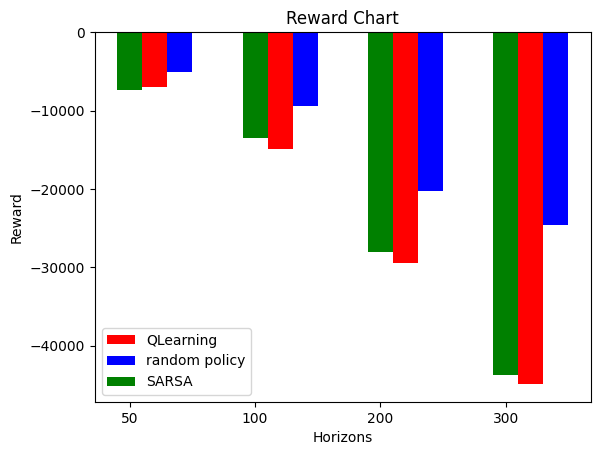

In [ ]:
horizons = [50, 100, 200, 300]
q_learning_bar_heights = []
random_policy_bar_heights = []
sarsa_bar_heights = []
states_per_policy = []
for h in horizons:
# heights of
  q_learning_reward, random_policy_reward, sarsa_reward, states_per_policy = evaluation(q_values, h)
  q_learning_bar_heights.append(q_learning_reward)
  random_policy_bar_heights.append(random_policy_reward)
  sarsa_bar_heights.append(sarsa_reward)

x_coords = [1, 2, 3, 4]
y_coords = [1.2, 2.2, 3.2, 4.2]
z_coords = [0.8, 1.8, 2.8, 3.8]
# plotting a bar chart
plt.bar(x_coords, q_learning_bar_heights, tick_label = horizons,
        width = 0.2, color = ['red'],label= "QLearning")
plt.bar(y_coords, random_policy_bar_heights, tick_label = horizons,
        width = 0.2, color = ['blue'], label = "random policy")
plt.bar(z_coords, sarsa_bar_heights, tick_label = horizons,
        width = 0.2, color = ['green'], label = "SARSA")

# naming the x-axis
plt.xlabel('Horizons')
# naming the y-axis
plt.ylabel('Reward')
# plot title
plt.title('Reward Chart')

#legend:
plt.legend()
# function to show the plot
plt.show()

0


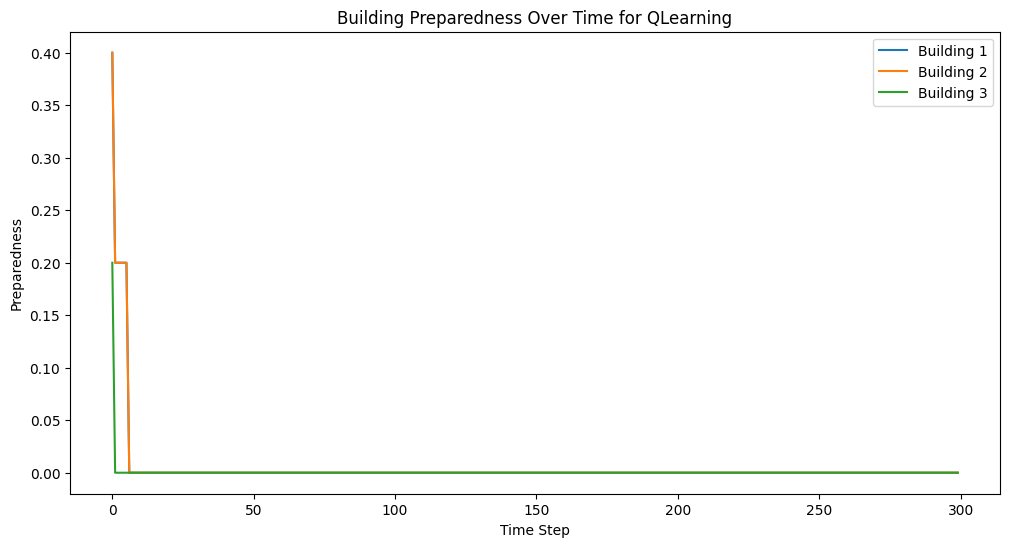

1


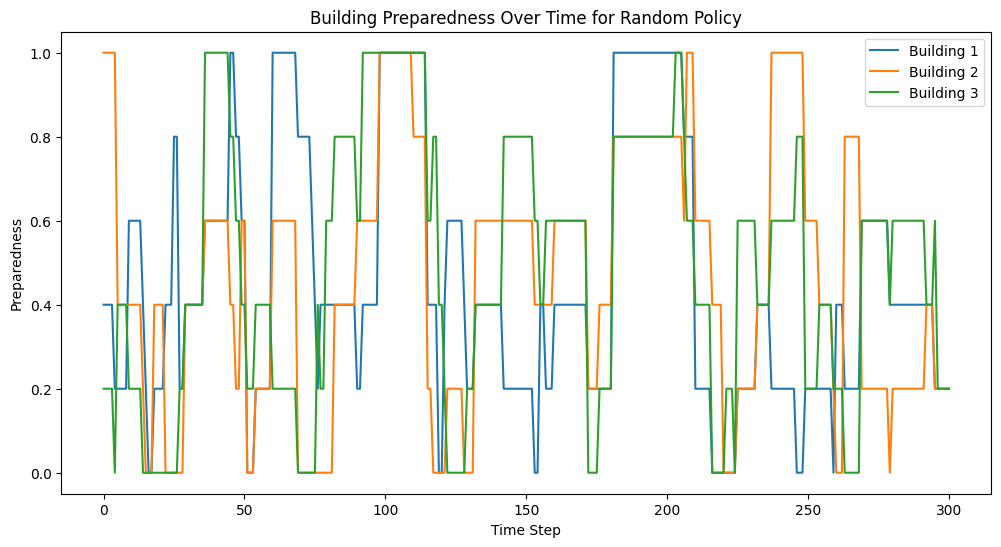

2


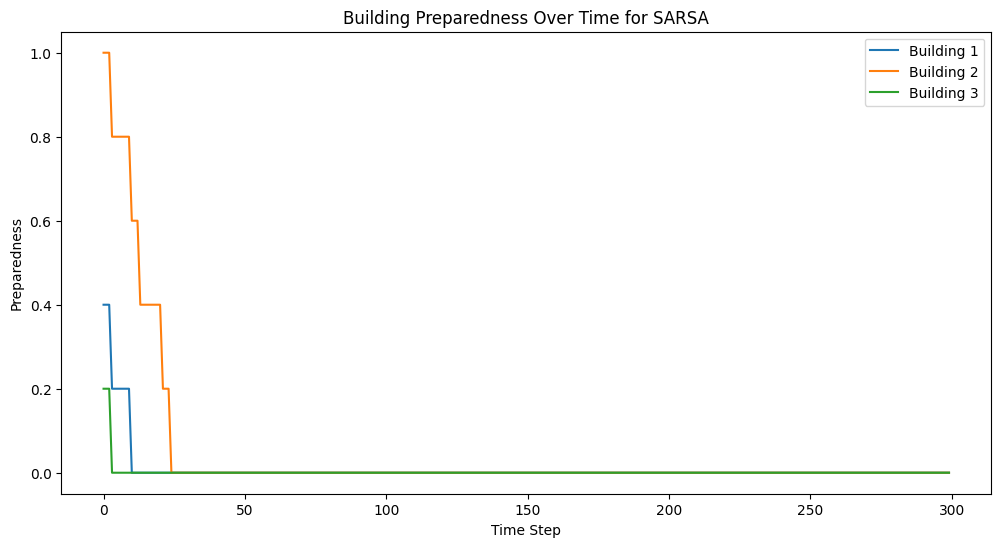

In [ ]:
for idx, states_over_time in enumerate(states_per_policy):
  d = {
      0: 'QLearning',
      1: 'Random Policy',
      2: 'SARSA'
  }
  print(idx)
  title = 'Building Preparedness Over Time for ' + d[idx]
  # Plotting the results
  plt.figure(figsize=(12, 6))
  for i in range(len(states_over_time[0])):
      plt.plot([state[i] for state in states_over_time], label=f'Building {i+1}')

  plt.xlabel('Time Step')
  plt.ylabel('Preparedness')
  plt.title(title )
  plt.legend()
  plt.show()

# Discussion

Our QLearning algorithm seems to do worse than a random policy. Let's take a look at some of the Q-values from our table:

In [ ]:
num_states = len(state_indexes.keys())
print("state:", q_values[0][:NUM_BUILD])
print("q_values:", q_values[0][NUM_BUILD:])
print("most optimal action", np.argmax(q_values[0][NUM_BUILD:]))
print("state:", q_values[1][:NUM_BUILD])
print("q_values:", q_values[1][NUM_BUILD:])
print("most optimal action", np.argmax(q_values[1][NUM_BUILD:]))

Our Qlearning algorithm seems to prioritize not renovating any buildings.

does this work when there are buildings that are above 0.2?

In [ ]:
print("state:", q_values[20][:NUM_BUILD])
print("q_values:", q_values[20][NUM_BUILD:])
print("most optimal action", np.argmax(q_values[20][NUM_BUILD:]))
print("state:", q_values[21][:NUM_BUILD])
print("q_values:", q_values[21][NUM_BUILD:])
print("most optimal action", np.argmax(q_values[21][NUM_BUILD:]))

In [ ]:
print("state:", q_values[215][:NUM_BUILD])
print("q_values:", q_values[215][NUM_BUILD:])

# Draft

In [ ]:
#TODO: COMMENT OUT

# def create_Q_table(NUM_BUILD):
#     # q_per_action = np.zeros(NUM_BUILD + 1)
#     # state_values = np.around(np.arange(0, 1.1, 0.2), decimals=1)
#     # # Generate all unique states:
#     # all_possible_states = list(itertools.product(state_values, repeat=NUM_BUILD))
#     # rows = []
#     # for i in range(len(all_possible_states)):
#     #   row = np.hstack((all_possible_states[i], q_per_action))
#     #   rows.append(row)
#     # matrix = np.vstack(rows)
#     # Generate all unique states:
#     state_values = np.around(np.arange(0, 1.1, 0.2), decimals=1)
#     all_possible_states = list(itertools.product(state_values, repeat=NUM_BUILD))
#     dict = {}
#     for s in all_possible_states:
#       dict[s] = {}
#       for j in range(len(action_space)):
#         dict[s][j] = 0
#     return dict

# matrix = create_Q_table(NUM_BUILD)
# print(matrix)
# print(len(matrix))


In [ ]:
# #dynamic qlearning:
# discount_factor = 0.9
# learning_rate =  0.01
# epsilon = 0.99

# def epsilon_greedy_exploration(epsilon, q_values, action_space, row):
#     if random.uniform(0, 1) < epsilon:
#         action = random.choice(action_space)  #Explore
#     else:
#         action = np.argmax(q_values[row][NUM_BUILD:])  #Exploit
#     return action
# def QLearning(curr_state,action_space, alpha, gamma, epsilon):
#     q_values = np.vstack([np.hstack((curr_state, np.zeros(len(action_space))))])
#     row = 0
#     num_renovations = 0
#     seen_states = {}
#     n = 1
#     for iter in range(1000000):
#       # We do epsilon greedy exploration to select the next action to take
#       seen_states[tuple(curr_state)] = row
#       action = epsilon_greedy_exploration(epsilon, q_values, action_space, row)
#       #We create the Q-Table dynamically:
#       next_state = transition(curr_state, action)
#       #Increment the number of renovations we've done:
#       if action > 0:
#         num_renovations += 1
#       #Get the reward:
#       r = reward(next_state, num_renovations)

#       if tuple(next_state) not in seen_states:
#         next_row = [np.hstack((next_state, np.zeros(len(action_space))))]
#         q_values = np.vstack((q_values, next_row))
#         #Update Qvalue:
#         q_values[row, NUM_BUILD + action] += alpha * (r + gamma * np.max(q_values[row + 1, NUM_BUILD:]) - q_values[row, NUM_BUILD + action])
#         #Update the current state and the row that we're looking at:
#         curr_state = next_state
#         row += 1
#       else:
#         #Update Qvalue:
#         q_values[row, NUM_BUILD + action] += alpha * (r + gamma * np.max(q_values[row, NUM_BUILD:]) - q_values[row, NUM_BUILD + action])
#       if iter > n * 100000:
#         n += 1
#         epsilon -= 0.2

#     return q_values
# q_vals = QLearning(state_space, action_space, discount_factor, learning_rate, epsilon)
# np.set_printoptions(formatter={'float': '{:0.3f}'.format})
# print(q_vals[:100])

